# The Impact of Multidimensional Opinions and Recommendation Algorithms on Social Network Polarization

### Author: Isabela Tellechea Coluccio

Code implemented for the completion of my Master's Degree in Computer Science at Universidad de Chile.



## Libraries and Initial Setup

In [1]:
# Import libraries

import numpy as np
import networkx as nx
import scipy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
import copy

!pip install gurobipy>=10.0.3
from gurobipy import *

In [ ]:
# Creation of Gurobi environment

env = Env(params={}) # IMPORTANT: Complete parameters with license information

## Creation of a Multidimensional Network

In [4]:
# Class definition and methods

class MDNetwork:
  """
  A class representing a multidimensional network with communities/groups.

  Attributes:
    sizes (list(int)): The sizes of the communities.
    probs (list(list(float))): Element [a,b] is the probability of edges between community a and b. It must be symmetric.
    means (list(list(float))): Element [a,b] is the mean of the intrinsic opinions from community a on topic b (default = [[0.0, 0.0], [0.0, 0.0]]).
    std (float): Standard deviation of the opinion distribution, it must be non-negative (default = 0.5).
    dim (int): The amount of topics (or dimensions) in the network (default = 2).
    lb (int): Minimum value of opinions (default = -1).
    ub (int): Maximum value of opinions (default =  1).
    s (ndarray): The intrinsic opinions of the participants in each topic.
    A (ndarray): A modified adjacency matrix of the network.
    D (ndarray): A modified degree matrix of the network.
    L (ndarray): A modified Laplacian matrix of the network.
  """

  def __init__(self, sizes, probs, means=[[0.0, 0.0], [0.0, 0.0]], std=0.5, dim=2, lb=-1, ub=1):
    """
    Initializes an MDNetwork object.

    Args:
      sizes (list(int)): The sizes of the communities.
      probs (list(list(float))): Element [a,b] is the probability of edges between community a and b. It must be symmetric.
      means (list(list(float))): Element [a,b] is the mean of the intrinsic opinions from community a on topic b (default = [[0.0, 0.0], [0.0, 0.0]]).
      std (float): Standard deviation of the opinion distribution, it must be non-negative (default = 0.5).
      dim (int): The amount of topics (or dimensions) in the network (default = 2).
      lb (int): Minimum value of opinions (default = -1)
      ub (int): Maximum value of opinions (default =  1)
    """
    # Attributes from parameters
    self.sizes = sizes
    self.probs = probs
    self.means = means
    self.std = std
    self.dim = dim
    self.lb = lb
    self.ub = ub
    # Attributes to set
    self.s = self.set_random_s()
    self.A = self.set_random_A()
    self.D = np.diag(np.sum(self.A, 0))
    self.L = self.D - self.A

  def set_random_s(self):
    """
    Defines a random set of intrinsic opinions, using a normal distribution.

    Returns:
      ndarray: The intrinsic opinions to be set for the network, it contains <# of participants> * <# of topics> elements.
    """
    s = np.zeros(np.sum(self.sizes) * self.dim)
    # Iterate through the topics in order to use different means for generating the opinions in each community
    for x in np.arange(self.dim):
      s_list = [np.random.default_rng().normal(self.means[i][x], self.std, self.sizes[i]) for i in range(len(self.sizes))]
      s_x = np.concatenate(s_list)
      s[np.arange(x, s.shape[0], self.dim)] = s_x
    # Set boundaries for the opinion values
    s = np.maximum(s, self.lb)
    s = np.minimum(s, self.ub)
    return s

  def set_random_A(self):
    """
    Defines a random network using a stochastic block model, obtaining a modified adjacency matrix.

    Returns:
      ndarray: The modified adjacency matrix of the generated network, it contains <# of participants> * <# of topics> rows and columns.
    """
    # Make sure the generated graph is connected
    i = 0
    found = False
    while i < 100000:
      G = nx.stochastic_block_model(self.sizes, self.probs)
      A = nx.to_numpy_array(G)
      if 0 not in [np.sum(column) for column in A]:
        found = True
        break
      i += 1
    assert found, "Couldn't define a complete network with those constraints"
    # Prepare new indices where the modified adjacency matrix will be != 0
    ix_1 = np.nonzero(A)
    d1 = np.tile(np.concatenate([ix_1[0] * self.dim + i for i in np.arange(self.dim)]), self.dim)
    d2 = np.concatenate([np.tile(ix_1[1] * self.dim + i, self.dim) for i in np.arange(self.dim)])
    new_ix = (d1, d2)
    # Create and fill the multidimensional adjacency matrix with random weights
    A = np.zeros([A.shape[0] * self.dim, A.shape[1] * self.dim])
    A[new_ix] = 1
    A = self.randomize_A(A)
    return A

  def randomize_A(self, A):
    """
    It modifies the given matrix randomizing its values.

    Args:
      A (ndarray): A matrix with only 1s and 0s.

    Returns:
      ndarray: The new matrix, maintaining the 0s and randomizing the 1s.
    """
    for i in np.arange(0, A.shape[0], self.dim):
      for j in np.arange(0, A.shape[0], self.dim):
        # Go through each index just once (on right upper half of the matrix)
        if i < j:
          diagonal = np.round(np.random.default_rng().uniform(low=2e-3, size=self.dim), 3)
          for x in np.arange(self.dim):
            for y in np.arange(self.dim):
              if A[i+x][j+y] == 0: continue
              if x == y:
                A[i+x][j+x] = diagonal[x]
                A[j+x][i+x] = diagonal[x]
              else:
                # Make sure weights are at least 1e-3 and lower than the diagonals
                new = np.round(np.random.default_rng().uniform(low=1e-3, high=min(diagonal)), 3)
                A[i+x][j+y] = new
                A[j+y][i+x] = new
                A[i+y][j+x] = new
                A[j+x][i+y] = new
    return A

  def update_MDN(self, A):
    """
    Given a new adjacency matrix, it modifies the internal matrices of the network.

    Args:
      A (ndarray): The new modified adjacency matrix, which is used to modifiy D and L.
    """
    self.A = A
    self.D = np.diag(np.sum(self.A, 0))
    self.L = self.D - self.A

  def get_z_eq(self):
    """
    Returns the equilibrium set of opinions for every topic.

    Returns:
      ndarray: An array with the equilibrium set of opinions of the network.
    """
    z_eq = la.solve(self.L + np.eye(self.L.shape[0]), self.s)
    return z_eq

  def get_z_eq_topic(self, t):
    """
    Returns the equilibrium set of opinions in one topic.

    Args:
      t (int): The topic selected.

    Returns:
      ndarray: An array with the equilibrium opinions only from topic t.
    """
    z_eq = self.get_z_eq()
    z_eq_topic = z_eq[np.arange(t, z_eq.shape[0], self.dim)]
    return z_eq_topic

  def get_A_topics(self, t1, t2):
    """
    Generates a submatrix of A corresponding to the data of two topics (For two-dimensional networks only).

    Args:
      t1 (int): The first topic.
      t2 (int): The second topic.

    Returns:
      ndarray: A submatrix of A containing entries for specific topics.
    """
    A_rows = self.A[np.arange(t1, self.A.shape[0], self.dim)]
    A_topics = A_rows[:, np.arange(t2, self.A.shape[1], self.dim)]
    return A_topics

  def get_D_topics(self, t1, t2):
    """
    Generates a submatrix of D corresponding to the data of two topics (For two-dimensional networks only).

    Args:
      t1 (int): The first topic.
      t2 (int): The second topic.

    Returns:
      ndarray: A submatrix of D containing entries for specific topics.
    """
    A_topics = self.get_A_topics(t1, t2)
    D_topics = np.diag(np.sum(A_topics,0))
    return D_topics

  def get_L_topics(self, t1, t2):
    """
    Generates a submatrix of L corresponding to the data of two topics (For two-dimensional networks only).

    Args:
      t1 (int): The first topic.
      t2 (int): The second topic.

    Returns:
      ndarray: A submatrix of L containing entries for specific topics.
    """
    A_topics = self.get_A_topics(t1, t2)
    D_topics = self.get_D_topics(t1, t2)
    L_topics = D_topics - A_topics
    return L_topics

  def get_s_topic(self, t):
    """
    Returns the intrinsic opinions in one topic.

    Args:
      t (int): The topic selected.

    Returns:
      ndarray: An array with the intrinsic opinions only from topic t.
    """
    s_topic = self.s[np.arange(t, self.s.shape[0], self.dim)]
    return s_topic


# Other functions

def get_D_eq(N):
  """
  Returns the disagreement of the network in the equilibrium state.

  Args:
    N (MDNetwork): The object that defines the network.

  Returns:
    ndarray: An array containing the disagreement for each topic.
  """
  D = np.zeros(N.dim)
  for x in np.arange(N.dim):
    for y in np.arange(N.dim):
      z_y = N.get_z_eq_topic(y)
      z_y_T = np.transpose(z_y)
      L_xy = N.get_L_topics(x, y)
      D[x] += z_y_T.dot(L_xy.dot(z_y))
  return D

def get_D_eq_1d(N, t):
  """
  Returns the disagreement of a two-dimensional network as if it was one-dimensional, for one topic.

  Args:
    N (MDNetwork): The object that defines the network.
    t (int): The topic selected.

  Returns:
    float: A number representing the disagreement in one topic.
  """
  L = N.get_L_topics(t, t)
  z_eq = la.solve(L + np.eye(L.shape[0]), N.get_s_topic(t))
  z_eq_T = np.transpose(z_eq)
  D = z_eq_T.dot(L.dot(z_eq))
  return D

def get_P_eq(N):
  """
  Returns the polarization of the network in the equilibrium state.

  Args:
    N (MDNetwork): The object that defines the network.

  Returns:
    ndarray: An array containing the polarization for each topic.
  """
  z_eq = [N.get_z_eq_topic(x) for x in np.arange(N.dim)]
  P = np.zeros(N.dim)
  for x in np.arange(N.dim):
    z_centered = z_eq[x] - np.mean(z_eq[x])
    P[x] = z_centered.dot(z_centered)
  return P

def get_P_eq_1d(N, t):
  """
  Returns the polarization of a two-dimensional network as if it was one-dimensional, for one topic.

  Args:
    N (MDNetwork): The object that defines the network.
    t (int): The topic selected.

  Returns:
    float: A number representing the polarization in one topic.
  """
  L = N.get_L_topics(t, t)
  z_eq = la.solve(L + np.eye(L.shape[0]), N.get_s_topic(t))
  z_centered = z_eq - np.mean(z_eq)
  P = z_centered.dot(z_centered)
  return P

def update_z(N, z_prev):
  """
  Makes one update to the set of opinions from a network, given the previous set.

  Args:
    N (MDNetwork): The object that defines the network.
    z_prev (ndarray): The previous set of opinions.

  Returns:
    ndarray: The next set of opinions.
  """
  z = la.solve(N.D + np.eye(N.D.shape[0]), N.A.dot(z_prev) + N.s)
  return z

def get_s_means(N, s):
  """
  Returns a list of the means of the intrinsic opinions given, in a way that element [a,b] represents the mean of group a on topic b.

  Args:
    N (MDNetwork): The object that defines the network.
    s (ndarray | MVar): An array representing the intrinsic opinions of the participants.

  Returns:
    list(ndarray): A list containing an ndarray for every group of the network, with the mean of their intrinsic opinions.
  """
  first = 0
  m = []
  for sz in N.sizes:
    group = []
    next = sz * N.dim
    s_group = s[first:first + next]
    for x in np.arange(N.dim):
      s_group_topic = s_group[np.arange(x, s_group.shape[0], N.dim)]
      s_mean = sum(s_group_topic) / s_group_topic.size
      group.append(s_mean)
    m.append(np.array(group))
    first = next
  return m

## Experiment 1: Convergence of Opinions

### Experimental Setup

In [5]:
def random_parameters(max_comms=4, max_users=20):
  """
  Generates random variables for creating a network (sizes, probs, means and std).

  Args:
    max_comms (int): The maximum amount of communities to generate.
    max_users (int): The maximum amount of participants per community.

  Returns:
    list(int): The sizes of the communities.
    list(list(float)): The edge probabilities.
    list(list(float)): The means of intrinsic opinions.
    float: The standard deviation.
  """
  rng = np.random.default_rng()

  # "sizes" (2 to <max_comms> communities, up to <max_users> participants each)
  comms = rng.integers(2, max_comms + 1)
  sizes = rng.integers(1, max_users + 1, size=comms).tolist()

  # "probs" (between communities must be lower than within communities)
  p_ins = rng.uniform((1/sum(sizes)) + 1e-3, 1, comms).tolist()
  probs = np.zeros((comms, comms))
  for i in np.arange(comms):
    for j in np.arange(comms):
      if i == j:
        probs[i][j] = p_ins[i]
      elif i < j:
        p_out = rng.uniform(1/sum(sizes), min(p_ins))
        probs[i][j] = p_out
        probs[j][i] = p_out
  probs = np.around(probs, 3).tolist()

  # "means" (for 2 topics)
  means = np.around(rng.uniform(-1, 1, (comms, 2)), 3).tolist()

  # "std" (any number between 0 and 1)
  std = np.around(np.random.rand(), 3)

  return sizes, probs, means, std

In [6]:
def convergence(networks=50, max_iters=400):
  """
  Creates the amount of networks given as parameter, updates them until reaching equilibrium and return data for all of them.

  Args:
    networks (int): The amount of networks to create.
    max_iters (int): The maximum iterations for a network to reach equilibrium.

  Returns:
    dict: A dictionary containing several lists with different metrics calculated for each network.
  """

  # Define dictionary to be filled with the networks' information
  data = {"sizes": [],
          "probs": [],
          "means": [],
          "std": [],
          "diffs": [],
          "diffs1": [],
          "diffs2": [],
          "ops": [],
          "ops1": [],
          "ops2": [],
          "final_iter": []}
  for i in np.arange(networks):
    print(f"Network {i + 1}...")
    # Create parameters and network
    sizes, probs, means, std = random_parameters()
    data["sizes"].append(sizes)
    data["probs"].append(probs)
    data["means"].append(means)
    data["std"].append(std)
    N = MDNetwork(sizes=sizes, probs=probs, means=means, std=std)
    # Calculate first opinions, and initialize variables
    z_prev = N.s
    z_next = update_z(N, z_prev)
    z_eq = N.get_z_eq()
    i = 0
    diffs = []
    diffs1 = []
    diffs2 = []
    ops = []
    ops1 = []
    ops2 = []
    # Complete lists until equilibrium is reached, or <max_iters> iterations are done
    while i < max_iters and np.linalg.norm(z_prev - z_next) > 1e-8:
      diffs.append(np.linalg.norm(z_prev - z_eq))
      diffs1.append(np.linalg.norm(z_prev[::2] - z_eq[::2]))
      diffs2.append(np.linalg.norm(z_prev[1::2] - z_eq[1::2]))
      ops.append(np.linalg.norm(z_prev))
      ops1.append(np.linalg.norm(z_prev[::2]))
      ops2.append(np.linalg.norm(z_prev[1::2]))
      z_prev = z_next
      z_next = update_z(N, z_prev)
      i += 1
    # Update last iteration
    diffs.append(np.linalg.norm(z_next - z_eq))
    diffs1.append(np.linalg.norm(z_next[::2] - z_eq[::2]))
    diffs2.append(np.linalg.norm(z_next[1::2] - z_eq[1::2]))
    ops.append(np.linalg.norm(z_next))
    ops1.append(np.linalg.norm(z_next[::2]))
    ops2.append(np.linalg.norm(z_next[1::2]))
    data["diffs"].append(diffs)
    data["diffs1"].append(diffs1)
    data["diffs2"].append(diffs2)
    data["ops"].append(ops)
    data["ops1"].append(ops1)
    data["ops2"].append(ops2)
    data["final_iter"].append(i)
  print("Done!")
  return data

In [ ]:
# Run experiment 1

conv_data = convergence()

### Results

#### Convergence

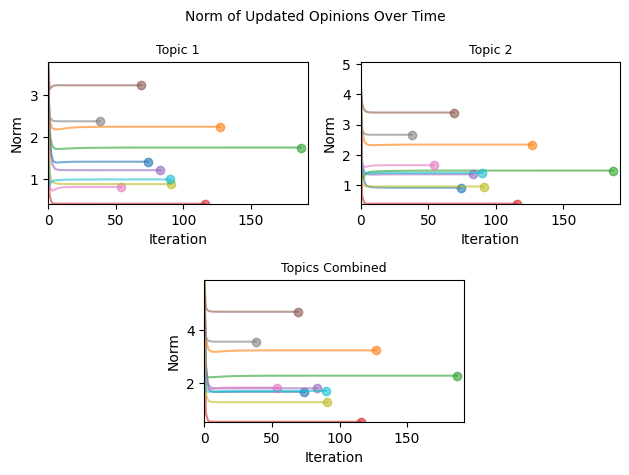

In [8]:
opi1 = conv_data["ops1"]
opi2 = conv_data["ops2"]
opinions = conv_data["ops"]
final_iter = conv_data["final_iter"][:10]

ax1 = plt.subplot2grid((4, 8), (0, 0), rowspan=2, colspan=4)
ax2 = plt.subplot2grid((4, 8), (0, 4), rowspan=2, colspan=4)
ax3 = plt.subplot2grid((4, 8), (2, 2), rowspan=2, colspan=4)

axs = [ax1, ax2, ax3]
ops = [opi1, opi2, opinions]
topics = ["Topic 1", "Topic 2", "Topics Combined"]

for i, ax in enumerate(axs):
  ax.margins(0,0)
  ax.set_xlim(right=max(final_iter)+5)
  for op in ops[i][:10]:
    ax.plot(op, marker='o', markevery=[-1], alpha=0.6)
  ax.set_title(topics[i], fontdict={"fontsize":9})
  ax.set_xlabel("Iteration", fontdict={"fontsize":10})
  ax.set_ylabel("Norm", fontdict={"fontsize":10})

plt.suptitle("Norm of Updated Opinions Over Time", fontsize=10)
plt.tight_layout()
plt.savefig("conv_update.pdf", bbox_inches="tight")
plt.show()

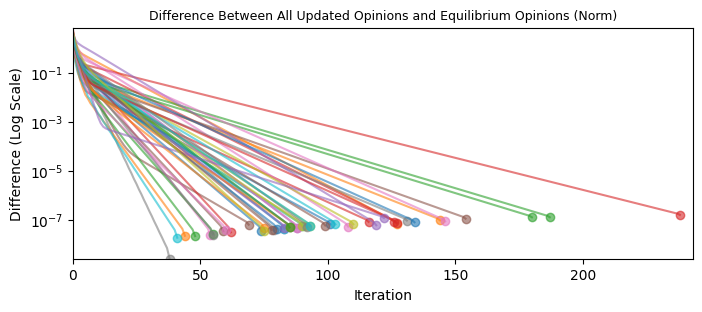

In [9]:
diffs = conv_data["diffs"]
diffs1 = conv_data["diffs1"]
diffs2 = conv_data["diffs2"]
final_iter = conv_data["final_iter"]

f, ax1 = plt.subplots(1, figsize=(8,3))

for d in diffs:
  ax1.plot(d, marker='o', markevery=[-1], alpha=0.6, zorder=1)
ax1.margins(0,0)
ax1.set_yscale("log")
ax1.set_xlim(right=max(final_iter)+5)

ax1.set_title("Difference Between All Updated Opinions and Equilibrium Opinions (Norm)", fontdict={"fontsize":9})
ax1.set_xlabel("Iteration", fontdict={"fontsize":10})
ax1.set_ylabel("Difference (Log Scale)", fontdict={"fontsize":10})
plt.savefig("conv_update_diff.pdf", bbox_inches="tight")
plt.show()

#### Edge Probabilities

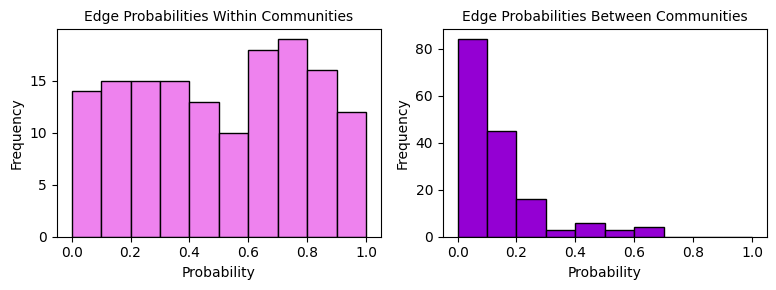

In [10]:
# Separate probabilities for plotting

probs_in = []
probs_out = []
for p in conv_data["probs"]:
  for i in range(len(p)):
    for j in range(len(p)):
      if i == j:
        probs_in.append(p[i][j])
      elif i < j:
        probs_out.append(p[i][j])


# Create plots

f, axs = plt.subplots(1, 2, figsize=(8,3))

titles = ["Within", "Between"]
colors = ["violet", "darkviolet"]
probs = [probs_in, probs_out]
bins = [np.arange(0, 1.1, 0.1).tolist(), np.arange(0, 1.1, 0.1).tolist()]

for i, ax in enumerate(f.axes):
  ax.hist(probs[i], bins=bins[i], edgecolor="black", color=colors[i])
  ax.set_title(f"Edge Probabilities {titles[i]} Communities", fontdict={"fontsize":10})
  ax.set_xlabel("Probability", fontdict={"fontsize":10})
  ax.set_ylabel("Frequency", fontdict={"fontsize":10})

plt.tight_layout()
plt.savefig("conv_probs.pdf", bbox_inches="tight")
plt.show()

#### Means of Intrinsic Opinions

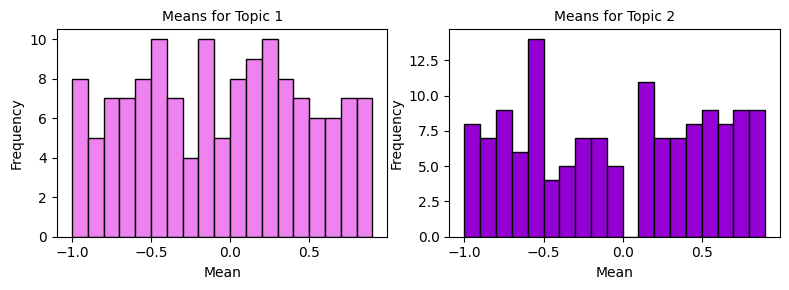

In [11]:
# Separate means for plotting

m_topic = {0: [], 1: []}
for n in conv_data["means"]:
  for m in n:
    for i in range(len(m)):
      m_topic[i].append(m[i])


# Create plots
f, axs = plt.subplots(1, 2, figsize=(8,3))

colors = ["violet", "darkviolet"]
bins = [np.arange(-1, 1, 0.1).tolist(), np.arange(-1, 1, 0.1).tolist()]

for i, ax in enumerate(f.axes):
  ax.hist(m_topic[i], bins=bins[i], edgecolor="black", color=colors[i])
  ax.set_title(f"Means for Topic {i + 1}", fontdict={"fontsize":10})
  ax.set_xlabel("Mean", fontdict={"fontsize":10})
  ax.set_ylabel("Frequency", fontdict={"fontsize":10})

plt.tight_layout()
plt.savefig("conv_means.pdf", bbox_inches="tight")
plt.show()

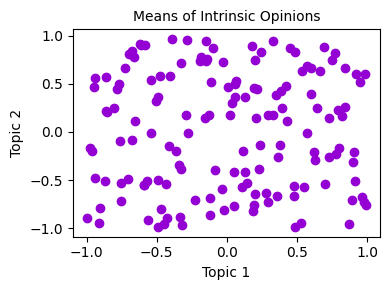

In [12]:
f, ax1 = plt.subplots(1, figsize=(4,3))

ax1.scatter(m_topic[0], m_topic[1], color="darkviolet")
ax1.set_title("Means of Intrinsic Opinions", fontdict={"fontsize":10})
ax1.set_xlabel("Topic 1", fontdict={"fontsize":10})
ax1.set_ylabel("Topic 2", fontdict={"fontsize":10})

plt.tight_layout()
plt.savefig("conv_means_scatter.pdf", bbox_inches="tight")
plt.show()

#### Standard Deviation of Intrinsic Opinions

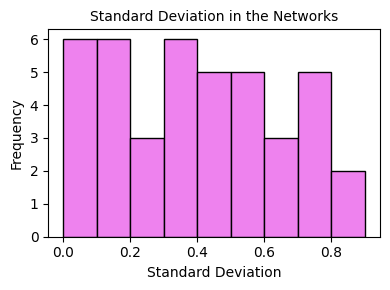

In [13]:
f, ax1 = plt.subplots(1, figsize=(4,3))

ax1.hist(conv_data["std"], bins=np.arange(0, 1, 0.1).tolist(), edgecolor="black", color="violet")
ax1.set_title("Standard Deviation in the Networks", fontdict={"fontsize":10})
ax1.set_xlabel("Standard Deviation", fontdict={"fontsize":10})
ax1.set_ylabel("Frequency", fontdict={"fontsize":10})

plt.tight_layout()
plt.savefig("conv_std.pdf", bbox_inches="tight")
plt.show()

## Experiment 2: Initial Conditions

### Experimental Setup

In [14]:
def random_probs_means():
  """
  Return random probabilities and means according to a certain classification.

  Returns:
    list(list(list(float))): Random probabilities for each case.
    list(list(list(float))): Random means of intrinsic opinions for each case.
  """
  rng = np.random.default_rng()

  means = np.round([
      [[rng.uniform(0.75, 1.0), rng.uniform(0.75, 1.0)], [rng.uniform(0.75, 1.0), rng.uniform(0.75, 1.0)]],
      [[rng.uniform(0.75, 1.0), rng.uniform(0.75, 1.0)], [rng.uniform(0.75, 1.0), rng.uniform(-1.0, -0.75)]],
      [[rng.uniform(0.75, 1.0), rng.uniform(0.75, 1.0)], [rng.uniform(-1.0, -0.75), rng.uniform(-1.0, -0.75)]],
      [[rng.uniform(0.75, 1.0), rng.uniform(-1.0, -0.75)], [rng.uniform(0.75, 1.0), rng.uniform(-1.0, -0.75)]],
      [[rng.uniform(0.75, 1.0), rng.uniform(-1.0, -0.75)], [rng.uniform(-1.0, -0.75), rng.uniform(0.75, 1.0)]]
  ], 2)

  out_comms = [rng.uniform(0.05, 0.15), rng.uniform(0.05, 0.15), rng.uniform(0.25, 0.35), rng.uniform(0.25, 0.35)]
  probs = np.round([
      [[rng.uniform(0.4, 0.5), out_comms[0]], [out_comms[0], rng.uniform(0.4, 0.5)]],
      [[rng.uniform(0.7, 0.8), out_comms[1]], [out_comms[1], rng.uniform(0.7, 0.8)]],
      [[rng.uniform(0.4, 0.5), out_comms[2]], [out_comms[2], rng.uniform(0.4, 0.5)]],
      [[rng.uniform(0.7, 0.8), out_comms[3]], [out_comms[3], rng.uniform(0.7, 0.8)]]
  ], 2)

  return probs, means

In [15]:
def get_ic_networks(p, m, sizes, iters=50):
  """
  Given specific cases for means and probabilities, generates <iters> two-dimensional networks, calculating some important metrics.

  Args:
    p (int): Case indicator for edge probabilities (0 to 3).
    m (int): Case indicator for means of intrinsic opinions (0 to 4).
    sizes (list(int)): The sizes of the communities.
    iters (int): The amount of networks to create.
  """
  data = {"dsg1": [],
          "dsg2": [],
          "plz1": [],
          "plz2": [],
          "probs": [],
          "means": [],
          "s": [],
          "dsg1d1": [],
          "plz1d1": [],
          "dsg1d2": [],
          "plz1d2": []}
  for z in np.arange(iters):
    print(f"Network {z + 1}...")
    probs, means = random_probs_means()
    N = MDNetwork(sizes=sizes, probs=probs[p], means=means[m])
    data["probs"].append(probs[p])
    data["means"].append(means[m])
    data["s"].append(N.s)
    data["dsg1"].append(get_D_eq(N)[0])
    data["plz1"].append(get_P_eq(N)[0])
    data["dsg2"].append(get_D_eq(N)[1])
    data["plz2"].append(get_P_eq(N)[1])
    data["dsg1d1"].append(get_D_eq_1d(N,0))
    data["plz1d1"].append(get_P_eq_1d(N,0))
    data["dsg1d2"].append(get_D_eq_1d(N,1))
    data["plz1d2"].append(get_P_eq_1d(N,1))
  return data

def initial_conditions():
  """
  Returns a combination of all the data collected from the networks in the different cases for probabilities and means of intrinsic opinions.

  Returns:
    ndarray: An array containing data for several networks in different initial conditions.
  """
  final = np.empty((4,5), dtype=dict)
  sizes = [20, 20]
  for p in range(4):
    for m in range(5):
      print(f"[Probabilities Case {p + 1} | Means Case {m + 1}]")
      final[p][m] = get_ic_networks(p, m, sizes)
  print("Done!")
  return final

In [ ]:
# Run experiment 2

ic_data = initial_conditions()

### Results

#### Topic Comparison

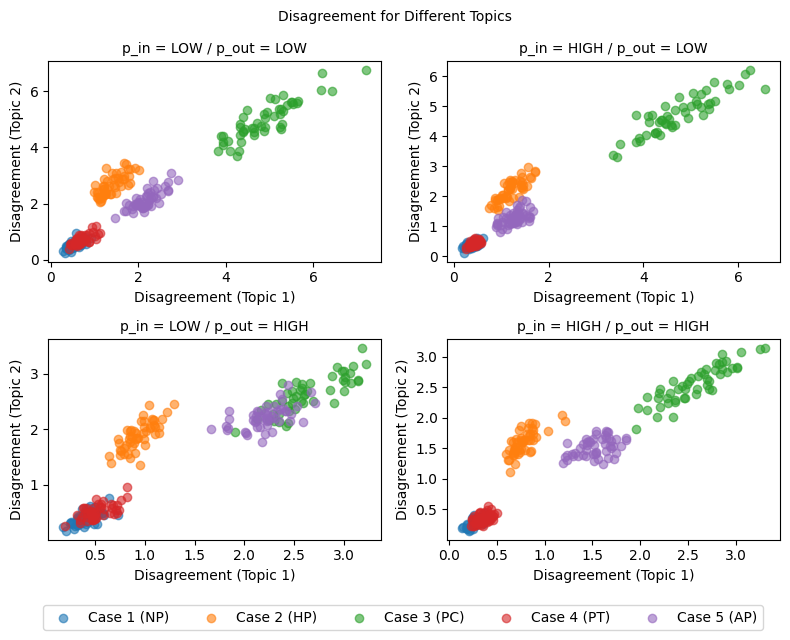

In [17]:
# Disagreement

cases = ["NP", "HP", "PC", "PT", "AP"]
titles = ["p_in = LOW / p_out = LOW",
          "p_in = HIGH / p_out = LOW",
          "p_in = LOW / p_out = HIGH",
          "p_in = HIGH / p_out = HIGH"]

f, axs = plt.subplots(2, 2, figsize=(8,6))

for i, ax in enumerate(f.axes):
    for j in range(5):
      dsg1 = ic_data[i][j]["dsg1"]
      dsg2 = ic_data[i][j]["dsg2"]
      ax.set_title(titles[i], fontdict={"fontsize":10})
      ax.set_xlabel("Disagreement (Topic 1)", fontdict={"fontsize":10})
      ax.set_ylabel("Disagreement (Topic 2)", fontdict={"fontsize":10})
      ax.scatter(dsg1, dsg2, label=f"Case {j+1} ({cases[j]})" if i==0 else "", alpha=0.6, zorder=5-i)

plt.suptitle("Disagreement for Different Topics", fontsize=10)
f.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.51, 0), ncol=5)
f.tight_layout()
plt.savefig("initial_d1d2.pdf", bbox_inches="tight")
plt.show()

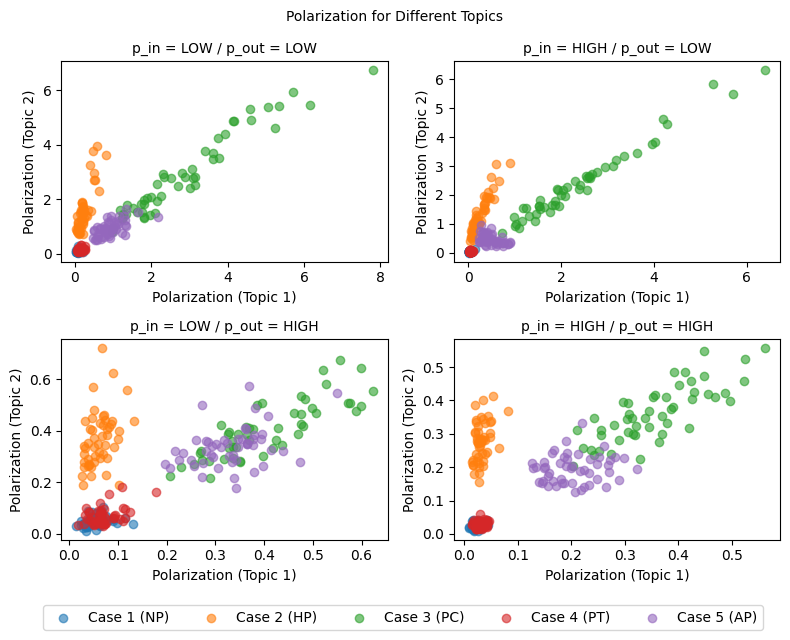

In [18]:
# Polarization

cases = ["NP", "HP", "PC", "PT", "AP"]
titles = ["p_in = LOW / p_out = LOW",
          "p_in = HIGH / p_out = LOW",
          "p_in = LOW / p_out = HIGH",
          "p_in = HIGH / p_out = HIGH"]

f, axs = plt.subplots(2, 2, figsize=(8,6))

for i, ax in enumerate(f.axes):
    for j in range(5):
      plz1 = ic_data[i][j]["plz1"]
      plz2 = ic_data[i][j]["plz2"]
      ax.set_title(titles[i], fontdict={"fontsize":10})
      ax.set_xlabel("Polarization (Topic 1)", fontdict={"fontsize":10})
      ax.set_ylabel("Polarization (Topic 2)", fontdict={"fontsize":10})
      ax.scatter(plz1, plz2, label=f"Case {j+1} ({cases[j]})" if i==0 else "", alpha=0.6, zorder=5-i)

plt.suptitle("Polarization for Different Topics", fontsize=10)
f.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.51, 0), ncol=5)
f.tight_layout()
plt.savefig("initial_p1p2.pdf", bbox_inches="tight")
plt.show()

#### Disagreement v/s Polarization

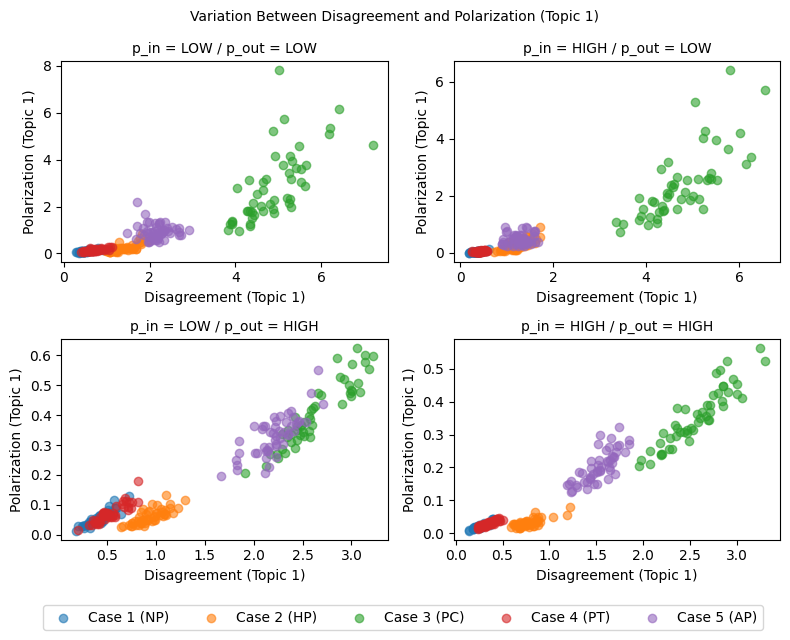

In [19]:
# Topic 1

cases = ["NP", "HP", "PC", "PT", "AP"]
titles = ["p_in = LOW / p_out = LOW",
          "p_in = HIGH / p_out = LOW",
          "p_in = LOW / p_out = HIGH",
          "p_in = HIGH / p_out = HIGH"]

f, axs = plt.subplots(2, 2, figsize=(8,6))

for i, ax in enumerate(f.axes):
    for j in range(5):
      dsg1 = ic_data[i][j]["dsg1"]
      plz1 = ic_data[i][j]["plz1"]
      ax.set_title(titles[i], fontdict={"fontsize":10})
      ax.set_xlabel("Disagreement (Topic 1)", fontdict={"fontsize":10})
      ax.set_ylabel("Polarization (Topic 1)", fontdict={"fontsize":10})
      ax.scatter(dsg1, plz1, label=f"Case {j+1} ({cases[j]})" if i==0 else "", alpha=0.6, zorder=5-i)

plt.suptitle("Variation Between Disagreement and Polarization (Topic 1)", fontsize=10)
f.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.51, 0), ncol=5)
f.tight_layout()
plt.savefig("initial_d1p1.pdf", bbox_inches="tight")
plt.show()

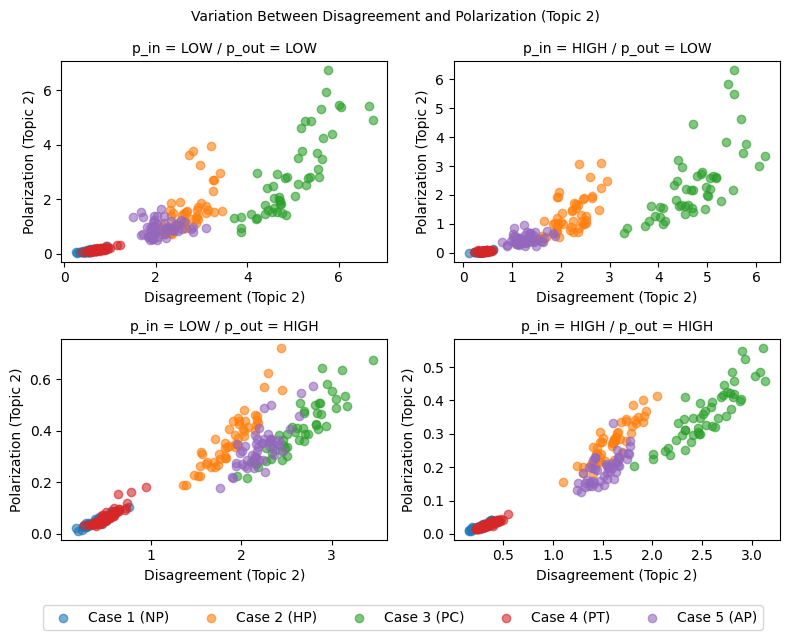

In [20]:
# Topic 2

cases = ["NP", "HP", "PC", "PT", "AP"]
titles = ["p_in = LOW / p_out = LOW",
          "p_in = HIGH / p_out = LOW",
          "p_in = LOW / p_out = HIGH",
          "p_in = HIGH / p_out = HIGH"]

f, axs = plt.subplots(2, 2, figsize=(8,6))

for i, ax in enumerate(f.axes):
    for j in range(5):
      dsg1 = ic_data[i][j]["dsg2"]
      plz1 = ic_data[i][j]["plz2"]
      ax.set_title(titles[i], fontdict={"fontsize":10})
      ax.set_xlabel("Disagreement (Topic 2)", fontdict={"fontsize":10})
      ax.set_ylabel("Polarization (Topic 2)", fontdict={"fontsize":10})
      ax.scatter(dsg1, plz1, label=f"Case {j+1} ({cases[j]})" if i==0 else "", alpha=0.6, zorder=5-i)

plt.suptitle("Variation Between Disagreement and Polarization (Topic 2)", fontsize=10)
f.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.51, 0), ncol=5)
f.tight_layout()
plt.savefig("initial_d2p2.pdf", bbox_inches="tight")
plt.show()

#### Dimensions Comparison

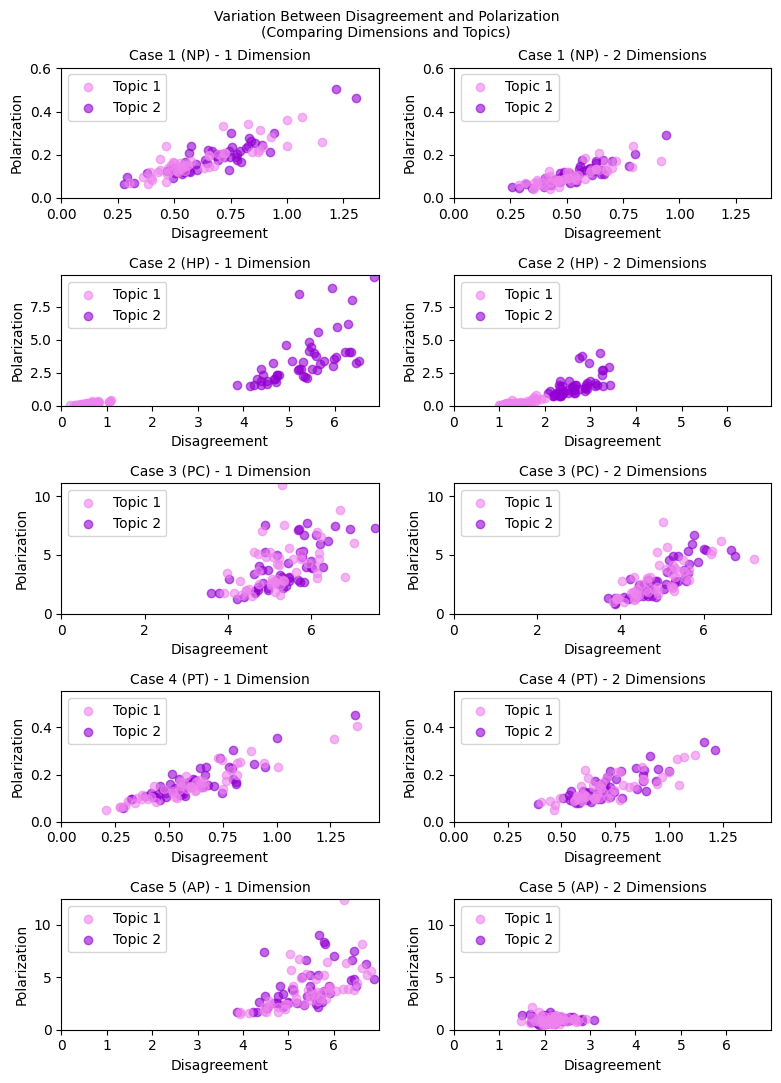

In [21]:
cases = ["NP", "NP", "HP", "HP", "PC", "PC", "PT", "PT", "AP", "AP"]
indices = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4]

f, ax = plt.subplots(5, 2, figsize=(8,11))

for j, ax in enumerate(f.axes):
  s = "s" if j%2!=0 else ""
  ax.set_title(f"Case {indices[j]+1} ({cases[j]}) - {(j%2)+1} Dimension{s}", fontdict={"fontsize":10})
  ax.set_xlabel("Disagreement", fontdict={"fontsize":10})
  ax.set_ylabel("Polarization", fontdict={"fontsize":10})
  dsg1 = ic_data[0][indices[j]]["dsg1"]
  plz1 = ic_data[0][indices[j]]["plz1"]
  dsg2 = ic_data[0][indices[j]]["dsg2"]
  plz2 = ic_data[0][indices[j]]["plz2"]
  dsg1d1 = ic_data[0][indices[j]]["dsg1d1"]
  plz1d1 = ic_data[0][indices[j]]["plz1d1"]
  dsg1d2 = ic_data[0][indices[j]]["dsg1d2"]
  plz1d2 = ic_data[0][indices[j]]["plz1d2"]
  ax.set_ylim(bottom=0, top=max(sum([plz1,plz2,plz1d1,plz1d2],[]))+0.1)
  ax.set_xlim(left=0, right=max(sum([dsg1,dsg2,dsg1d1,dsg1d2],[]))+0.1)
  if j%2==0:
    ax.scatter(dsg1d1, plz1d1, label="Topic 1", color="violet", alpha=0.6,  zorder=1)
    ax.scatter(dsg1d2, plz1d2, label="Topic 2", color="darkviolet", alpha=0.6,  zorder=0)
  else:
    ax.scatter(dsg1, plz1, label="Topic 1", color="violet", alpha=0.6,  zorder=1)
    ax.scatter(dsg2, plz2, label="Topic 2", color="darkviolet", alpha=0.6,  zorder=0)
  ax.legend(fontsize=10, loc="upper left")

plt.suptitle("Variation Between Disagreement and Polarization\n(Comparing Dimensions and Topics)", fontsize=10)
f.tight_layout()
plt.savefig("initial_dp_1d.pdf", bbox_inches="tight")
plt.show()

## Experiment 3: Recommendation Algorithm

### Experimental Setup

In [22]:
def min_dsg_on_A(N, lam, regularized, gam):
  """
  Defines and executes a Gurobi model for obtaining the modified adjacency matrix of a given network N that minimizes its disagreement. It
  is designed to allow only 2 dimensions of topics.

  Args:
    N (MDNetwork): The object that defines the network.
    lam (float): A parameter that controls how much the optimization process can change the edge weights.
    regularized (bool): Indicates if the process is regularized or not.
    gam (float): If the process is regularized, this is a parameter that adjusts the level of regularization.

  Returns:
    ndarray: An array containing the modified adjacency matrix that minimize the disagreement of the model.
  """
  # Define initial variables and optimization variables as matrix
  m = Model("min_dsg_on_A", env=env)
  n = np.sum(N.sizes)
  a = m.addMVar((2 * n, 2 * n), vtype=GRB.CONTINUOUS, name="a")

  # Calculate objective function and add first 2 constraints (only change nodes that already have weights)
  dsg = 0
  for i in np.arange(n):
    for j in np.arange(n):
      for x in np.arange(N.dim):
        for y in np.arange(N.dim):
          # Get value for disagreement
          zy = N.get_z_eq_topic(y)
          i_x = 2 * i + x
          j_y = 2 * j + y
          if i < j:
            dsg += a[i_x, j_y] * ((zy[i] - zy[j]) ** 2)
          # Add 1st constraint
          if N.A[i_x, j_y] == 0:
             m.addConstr(a[i_x, j_y] == 0)
          # Add 2nd constraint
          else:
             m.addConstr(a[i_x, j_y] >= 1e-3)
             m.addConstr(a[i_x, j_y] <= 0.9999999)

  # If the dynamics are regularized, add gamma term
  if regularized: dsg += gam * sum(sum((a * a)))

  # Add 3rd constraint (keep N.D the same)
  d = np.sum(N.A, 0)
  m.addConstr(np.sum(N.A) == a.sum())

  # Add 4th constraint (matrix must be symmetric)
  m.addConstr(a.T == a)

  # Add 5th constraint (submatrices must be symmetric)
  for i in np.arange(n):
    for j in np.arange(n):
      sub_a = a[(2 * i):(2 * i + 2), (2 * j):(2 * j + 2)]
      sub_A = N.A[(2 * i):(2 * i + 2), (2 * j):(2 * j + 2)]
      m.addConstr(sub_a.T == sub_a)
      # Add 6th constraint (change submatrices through a factor)
      if sub_A[0,0] != 0:
        m.addConstr(sub_a[0,0]/sub_A[0,0] == sub_a[1,0]/sub_A[1,0])
        m.addConstr(sub_a[0,0]/sub_A[0,0] == sub_a[1,1]/sub_A[1,1])
        m.addConstr(sub_a[0,0]/sub_A[0,0] == sub_a[0,1]/sub_A[0,1])

  # Add 7th constraint (limit edge weight changes)
  limit = (lam * la.norm(N.A)) ** 2
  m.addConstr(sum(sum((a - N.A) * (a - N.A))) <= limit) # Equivalent to obtaining the norm of the difference squared

  # Set objective function as the sum of the disagreement per topic, optimize and return final A
  m.setObjective(dsg, GRB.MINIMIZE)
  m.optimize()
  return a.X

In [23]:
def random_probs_means():
  """
  Return random probabilities and means according to a certain classification.

  Returns:
    list(list(list(float))): Random probabilities for each case.
    list(list(list(float))): Random means of intrinsic opinions for each case.
  """
  rng = np.random.default_rng()

  means = np.round([
      [[rng.uniform(0.75, 1.0), rng.uniform(0.75, 1.0)], [rng.uniform(0.75, 1.0), rng.uniform(0.75, 1.0)]],
      [[rng.uniform(0.75, 1.0), rng.uniform(0.75, 1.0)], [rng.uniform(0.75, 1.0), rng.uniform(-1.0, -0.75)]],
      [[rng.uniform(0.75, 1.0), rng.uniform(0.75, 1.0)], [rng.uniform(-1.0, -0.75), rng.uniform(-1.0, -0.75)]],
      [[rng.uniform(0.75, 1.0), rng.uniform(-1.0, -0.75)], [rng.uniform(0.75, 1.0), rng.uniform(-1.0, -0.75)]],
      [[rng.uniform(0.75, 1.0), rng.uniform(-1.0, -0.75)], [rng.uniform(-1.0, -0.75), rng.uniform(0.75, 1.0)]]
  ], 2)

  out_comms = [rng.uniform(0.05, 0.15), rng.uniform(0.05, 0.15), rng.uniform(0.25, 0.35), rng.uniform(0.25, 0.35)]
  probs = np.round([
      [[rng.uniform(0.4, 0.5), out_comms[0]], [out_comms[0], rng.uniform(0.4, 0.5)]],
      [[rng.uniform(0.7, 0.8), out_comms[1]], [out_comms[1], rng.uniform(0.7, 0.8)]],
      [[rng.uniform(0.4, 0.5), out_comms[2]], [out_comms[2], rng.uniform(0.4, 0.5)]],
      [[rng.uniform(0.7, 0.8), out_comms[3]], [out_comms[3], rng.uniform(0.7, 0.8)]]
  ], 2)

  return probs, means

In [24]:
def alternate_min(N, lam, regularized, gam, max_iters=100):
  """
  Simulates the alternating minimization process.

  Args:
    N (MDNetwork): The object that defines the network.
    lam (float): A parameter that controls how much the optimization process can change the edge weights.
    regularized (bool): Indicates if the process is regularized or not.
    gam (float): If the process is regularized, this is a parameter that adjusts the level of regularization.
    max_iters (int): The maximum amount of iterations the process will do.

  Returns:
    dict: A dictionary containing lists of metrics for every iteration of the process.
  """
  data = {"dsg1": [],
          "dsg2": [],
          "plz1": [],
          "plz2": [],
          "ds": []}
  data["A_0"] = N.A
  z_prev = N.get_z_eq()
  A_prev = N.A
  data["dsg1"].append(get_D_eq(N)[0])
  data["dsg2"].append(get_D_eq(N)[1])
  data["plz1"].append(get_P_eq(N)[0])
  data["plz2"].append(get_P_eq(N)[1])
  i = 0
  while True:
    print(f"Iteration {i + 1}...")
    A_next = min_dsg_on_A(N, lam, regularized, gam)
    N.update_MDN(A_next)
    z_next = N.get_z_eq()
    data["dsg1"].append(get_D_eq(N)[0])
    data["dsg2"].append(get_D_eq(N)[1])
    data["plz1"].append(get_P_eq(N)[0])
    data["plz2"].append(get_P_eq(N)[1])
    i += 1
    if i >= max_iters or max(la.norm(z_prev - z_next), la.norm(A_prev - A_next)) < 1e-4:
      break
    z_prev = z_next
    A_prev = A_next
  data["A_fin"] = A_next
  data["final_iter"] = i
  return data

def recommendation_algorithm(networks=10, lam=0.2, gam=0.2, p=0, m=1):
  """
  Executes the process of alternating minimization in several networks, obtaining their metrics in every step.

  Args:
    networks (int): The amount of sample networks created.
    lam (float): A parameter that controls how much the optimization process can change the edge weights.
    gam (float): If the process is regularized, this is a parameter that adjusts the level of regularization.
    p (int): Case indicator for edge probabilities (0 to 3).
    m (int): Case indicator for means of intrinsic opinions (0 to 4).
  """
  sizes = [20, 20]
  data = {"reg": [],
          "nonreg": [],
          "probs": [],
          "means": []}
  for i in np.arange(networks):
    print(f"Network {i + 1}...")
    probs, means = random_probs_means()
    N = MDNetwork(sizes=sizes, probs=probs[p], means=means[m], std=0.5)
    N1 = copy.deepcopy(N)
    N2 = copy.deepcopy(N)
    nr = alternate_min(N1, lam, regularized=False, gam=0, max_iters=50)
    r = alternate_min(N2, lam, regularized=True, gam=gam, max_iters=50)
    data["reg"].append(r)
    data["nonreg"].append(nr)
    data["probs"].append(probs[p])
    data["means"].append(means[m])
  print("Done!")
  return data

In [ ]:
# Run experiment 3 (once for every case of means needed)

rec_alg_data = recommendation_algorithm()

### Results

#### Evolution of Disagreement and Polarization

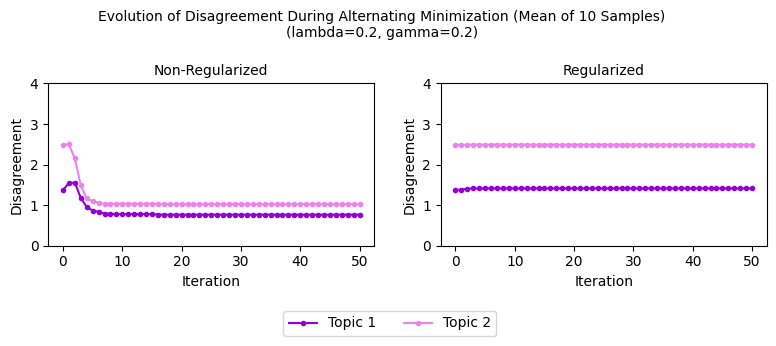

In [30]:
f, axs = plt.subplots(1, 2, figsize=(8,3))

nr_list = rec_alg_data["nonreg"]
r_list = rec_alg_data["reg"]
lists = [nr_list, r_list]
titles = ["Non-Regularized", "Regularized"]

for i, ax in enumerate(f.axes):
  ax.set_title(titles[i], fontdict={"fontsize":10})
  ax.set_xlabel("Iteration", fontdict={"fontsize":10})
  ax.set_ylabel("Disagreement", fontdict={"fontsize":10})
  dsg1 = [n["dsg1"] + [n["dsg1"][-1]] * (51-len(n["dsg1"])) for n in lists[i]]
  m_1 = np.mean(dsg1, axis=0)
  dsg2 = [n["dsg2"] + [n["dsg2"][-1]] * (51-len(n["dsg2"])) for n in lists[i]]
  m_2 = np.mean(dsg2, axis=0)
  ax.plot(m_1, label="Topic 1" if i==0 else "", marker=".", color="darkviolet")
  ax.plot(m_2, label="Topic 2" if i==0 else "", marker=".", color="violet")
  ax.set_ylim(bottom=0, top=4) # Adjust according to the results

plt.suptitle("Evolution of Disagreement During Alternating Minimization (Mean of 10 Samples)\n(lambda=0.2, gamma=0.2)", fontsize=10)
f.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.51, 0), ncol=2)
plt.tight_layout()
plt.savefig("dsg_ev_both_m.pdf", bbox_inches="tight")
plt.show()

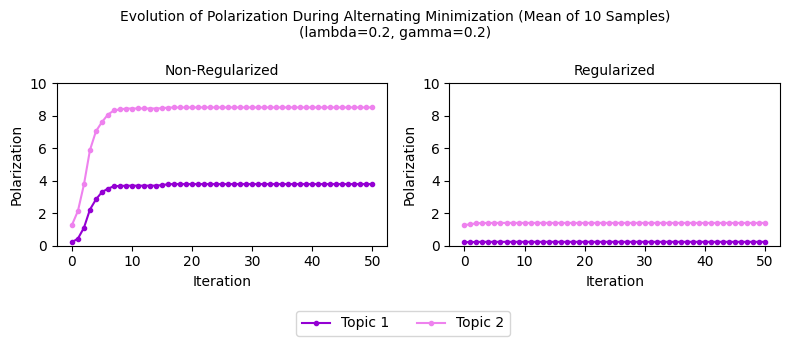

In [31]:
f, axs = plt.subplots(1, 2, figsize=(8,3))

nr_list = rec_alg_data["nonreg"]
r_list = rec_alg_data["reg"]
lists = [nr_list, r_list]
titles = ["Non-Regularized", "Regularized"]

for i, ax in enumerate(f.axes):
  ax.set_title(titles[i], fontdict={"fontsize":10})
  ax.set_xlabel("Iteration", fontdict={"fontsize":10})
  ax.set_ylabel("Polarization", fontdict={"fontsize":10})
  plz1 = [n["plz1"] + [n["plz1"][-1]] * (51-len(n["plz1"])) for n in lists[i]]
  m_1 = np.mean(plz1, axis=0)
  plz2 = [n["plz2"] + [n["plz2"][-1]] * (51-len(n["plz2"])) for n in lists[i]]
  m_2 = np.mean(plz2, axis=0)
  ax.plot(m_1, label="Topic 1" if i==0 else "", marker=".", color="darkviolet")
  ax.plot(m_2, label="Topic 2" if i==0 else "", marker=".", color="violet")
  ax.set_ylim(bottom=0, top=10) # Adjust according to the results

plt.suptitle("Evolution of Polarization During Alternating Minimization (Mean of 10 Samples)\n(lambda=0.2, gamma=0.2)", fontsize=10)
f.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.51, 0), ncol=2)
plt.tight_layout()
plt.savefig("plz_ev_both_m.pdf", bbox_inches="tight")
plt.show()

#### Changes in Disagreement and Polarization

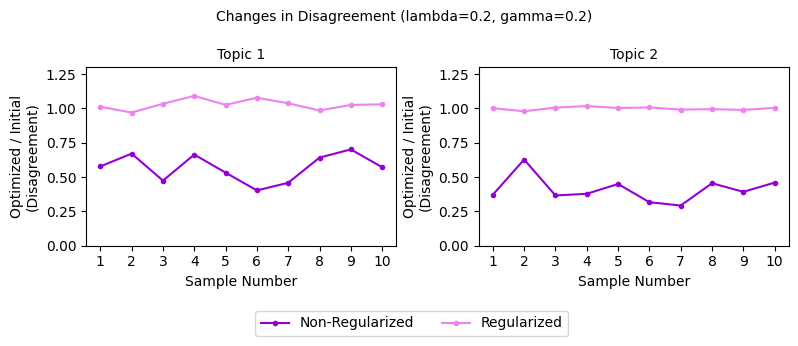

In [32]:
f, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,3))

nr_list = rec_alg_data["nonreg"]
r_list = rec_alg_data["reg"]
lists = [nr_list, r_list]
titles = ["Topic 1", "Topic 2"]
topic = ["dsg1", "dsg2"]

for i, ax in enumerate(f.axes):
  ax.set_title(titles[i], fontdict={"fontsize":10})
  ax.set_xlabel("Sample Number", fontdict={"fontsize":10})
  ax.set_ylabel("Optimized / Initial\n(Disagreement)", fontdict={"fontsize":10})
  nr = [n[topic[i]][-1] / n[topic[i]][0] for n in nr_list]
  r =  [n[topic[i]][-1]  / n[topic[i]][0]  for n in r_list]
  x = np.arange(1,11)
  ax.plot(x, nr, label="Non-Regularized" if i==0 else "", marker=".", color="darkviolet")
  ax.plot(x, r, label="Regularized" if i==0 else "", marker=".", color="violet")
  ax.set_ylim(bottom=0, top=1.3) # Adjust according to the results
  ax.set_xticks(x)

plt.suptitle("Changes in Disagreement (lambda=0.2, gamma=0.2)", fontsize=10)
f.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.51, 0), ncol=2)
plt.tight_layout()
plt.savefig("dsg_ch.pdf", bbox_inches="tight")
plt.show()

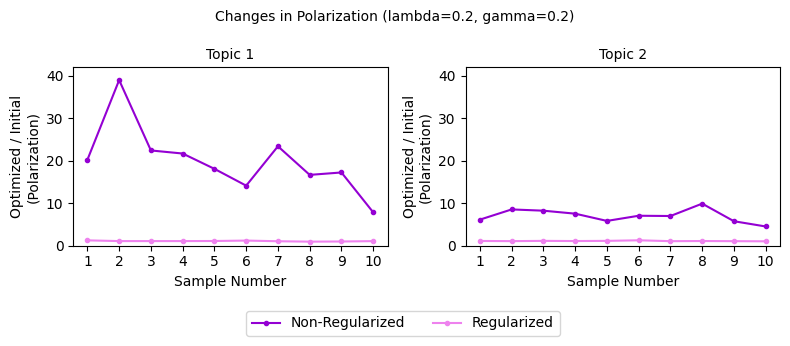

In [35]:
f, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,3))

nr_list = rec_alg_data["nonreg"]
r_list = rec_alg_data["reg"]
lists = [nr_list, r_list]
titles = ["Topic 1", "Topic 2"]
topic = ["plz1", "plz2"]

for i, ax in enumerate(f.axes):
  ax.set_title(titles[i], fontdict={"fontsize":10})
  ax.set_xlabel("Sample Number", fontdict={"fontsize":10})
  ax.set_ylabel("Optimized / Initial\n(Polarization)", fontdict={"fontsize":10})
  nr = [n[topic[i]][-1] / n[topic[i]][0] for n in nr_list]
  r =  [n[topic[i]][-1]  / n[topic[i]][0]  for n in r_list]
  x = np.arange(1,11)
  ax.plot(x, nr, label="Non-Regularized" if i==0 else "", marker=".", color="darkviolet")
  ax.plot(x, r, label="Regularized" if i==0 else "", marker=".", color="violet")
  ax.set_ylim(bottom=0, top=42) # Adjust according to the results
  ax.set_xticks(x)

plt.suptitle("Changes in Polarization (lambda=0.2, gamma=0.2)", fontsize=10)
f.legend(fontsize=10, loc="upper center", bbox_to_anchor=(0.51, 0), ncol=2)
plt.tight_layout()
plt.savefig("plz_ch.pdf", bbox_inches="tight")
plt.show()